<a href="https://colab.research.google.com/github/thuongvan23/XAI-LandCover/blob/thuongVTH/T_Capstone_process_BigEarth_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Document for Capstone/bigearthnet_12band_10m.zip" -d /content/

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/content/bigearthnet_12band_10m/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_41_60_12band.tif  
  inflating: /content/content/bigearthnet_12band_10m/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_85_77_12band.tif  
  inflating: /content/content/bigearthnet_12band_10m/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_24_70_12band.tif  
  inflating: /content/content/bigearthnet_12band_10m/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_78_86_12band.tif  
  inflating: /content/content/bigearthnet_12band_10m/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_14_53_12band.tif  
  inflating: /content/content/bigearthnet_12band_10m/S2A_MSIL2A_20170704T112111_N9999_R037_T29SND/S2A_MSIL2A_20170704T112111_N9999_R0

In [ ]:
import os

# Đường dẫn thư mục chứa ảnh đa phổ đã xử lý
data_dir = "/content/content/bigearthnet_12band_10m"

class_counts = {}
total_images = 0

for label in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, label)
    if os.path.isdir(class_path):
        n_files = len([f for f in os.listdir(class_path) if f.endswith('.tif')])
        class_counts[label] = n_files
        total_images += n_files

# In kết quả
print("Số lượng ảnh mỗi class:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} ảnh")

print(f"\nTổng số ảnh: {total_images}")

Số lượng ảnh mỗi class:
Class S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP: 3305 ảnh
Class S2A_MSIL2A_20170613T101031_N9999_R022_T34VER: 6686 ảnh
Class S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU: 7986 ảnh
Class S2A_MSIL2A_20170701T093031_N9999_R136_T35VPK: 7997 ảnh
Class S2A_MSIL2A_20170704T112111_N9999_R037_T29SND: 8216 ảnh
Class S2A_MSIL2A_20170717T113321_N9999_R080_T29UPA: 370 ảnh
Class S2A_MSIL2A_20170717T113321_N9999_R080_T29UPV: 6013 ảnh
Class S2A_MSIL2A_20170720T100031_N9999_R122_T34UDG: 1540 ảnh
Class S2A_MSIL2A_20170803T094031_N9999_R036_T34TCR: 4864 ảnh
Class S2A_MSIL2A_20170813T112121_N9999_R037_T29SNC: 8222 ảnh

Tổng số ảnh: 55199


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 56.1 MB/s eta 0:00:00


Shape của ảnh S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_28_85_12band.tif: (12, 120, 120) (channels, height, width)


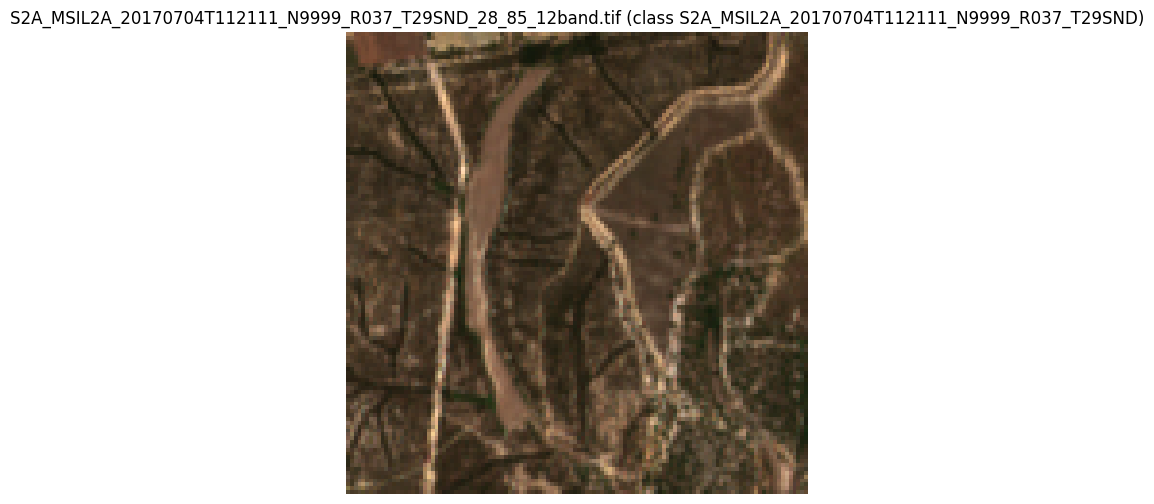

In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import random

# Chọn ngẫu nhiên 1 class và 1 ảnh trong class
random_class = random.choice(os.listdir(data_dir))
img_path = os.path.join(data_dir, random_class)
random_img = random.choice([f for f in os.listdir(img_path) if f.endswith('.tif')])
img_full_path = os.path.join(img_path, random_img)

# Đọc ảnh
with rasterio.open(img_full_path) as src:
    img = src.read()  # shape: (12, H, W)

# In shape
print(f"Shape của ảnh {random_img}: {img.shape} (channels, height, width)")

# Hiển thị ảnh (dùng band 4,3,2 tương ứng RGB)
rgb = np.stack([img[3], img[2], img[1]], axis=-1)  # Chú ý chỉ số bắt đầu từ 0
rgb = rgb.astype(np.float32)
rgb /= np.max(rgb) + 1e-6  # Chuẩn hóa để hiển thị

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title(f"{random_img} (class {random_class})")
plt.axis('off')
plt.show()


In [ ]:
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split

# Gốc thư mục lưu các ảnh đã xử lý (12 band)
DATA_DIR = "/content/content/bigearthnet_12band_10m"

# Thiết lập tỉ lệ chia
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Đảm bảo tái lập kết quả
random.seed(42)

# Danh sách ảnh và nhãn
train_list = []
val_list = []
test_list = []

# Duyệt qua 10 class (0-9)
for class_label in sorted(os.listdir(DATA_DIR)):
    class_dir = os.path.join(DATA_DIR, class_label)
    if not os.path.isdir(class_dir):
        continue

    # Lấy tất cả ảnh .tif trong class
    image_paths = glob(os.path.join(class_dir, "*.tif"))
    if len(image_paths) < 5:
        continue  # bỏ qua nếu ít ảnh

    # Shuffle
    random.shuffle(image_paths)

    # Chia train/val/test
    train_images, temp = train_test_split(image_paths, train_size=train_ratio, random_state=42)
    val_images, test_images = train_test_split(temp, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

    # Gán nhãn
    # Nếu bạn chỉ cần giữ nhãn là tên folder (chuỗi)
    train_list.extend([(path, class_label) for path in train_images])
    val_list.extend([(path, class_label) for path in val_images])
    test_list.extend([(path, class_label) for path in test_images])


print(f"Số ảnh train: {len(train_list)}")
print(f"Số ảnh val: {len(val_list)}")
print(f"Số ảnh test: {len(test_list)}")


Số ảnh train: 38636
Số ảnh val: 8280
Số ảnh test: 8283


In [ ]:
!pip install albumentations

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    # A.Normalize(mean=[0]*12, std=[1]*12, max_pixel_value=1.0),

    # A.Resize(244, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=0.0, std=1.0, max_pixel_value=1.0),
    # ToTensorV2(transpose_mask=True),
])

val_transform = A.Compose([
    # A.Resize(224, 224),
    A.Normalize(mean=[0]*12, std=[1]*12, max_pixel_value=1.0),
    # ToTensorV2(transpose_mask=False)
])


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

# Tạo encoder
label_encoder = LabelEncoder()

# Fit label encoder từ train_list
all_labels = [label for _, label in train_list]
label_encoder.fit(all_labels)
NUM_CLASSES = len(label_encoder.classes_)

# Dataset mới sử dụng LabelEncoder
class BigEarthNetDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        with rasterio.open(img_path) as src:
            image = src.read()  # (12, H, W)
        image = image.astype(np.float32) / 10000.0
        image = np.transpose(image, (1, 2, 0))  # (H, W, C)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        else:
            image = torch.tensor(np.transpose(image, (2, 0, 1)))  # (C, H, W)

        label = label_encoder.transform([label])[0]  # chuyển label thành số nguyên
        return torch.tensor(image).permute(2, 0, 1), label  # (C, H, W)


In [ ]:
from torch.utils.data import DataLoader
import torch
import tifffile as tiff

# Batch size
BATCH_SIZE = 16

# Dataset
train_dataset = BigEarthNetDataset(train_list, transform=train_transform)
val_dataset = BigEarthNetDataset(val_list, transform=val_transform)
test_dataset = BigEarthNetDataset(test_list, transform=val_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

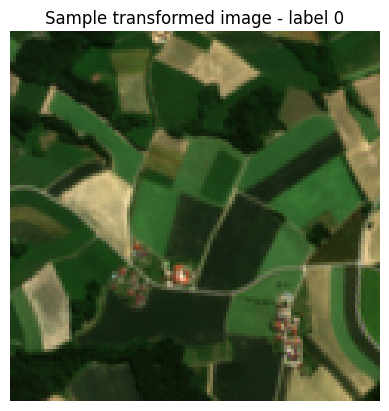

In [ ]:
# Lấy 1 mẫu bất kỳ từ train_dataset
sample_img, sample_label = train_dataset[0]

# Chuyển tensor về numpy để hiển thị
sample_img_np = sample_img.numpy().transpose(1, 2, 0)  # (H, W, C)

# Lấy lại các band RGB (band 4, 3, 2 --> index 3, 2, 1)
rgb = sample_img_np[:, :, [3, 2, 1]]

# Chuẩn hóa về [0, 1] nếu cần (nếu bạn đã normalize thì giá trị có thể lệch)
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)

import matplotlib.pyplot as plt
plt.imshow(rgb)
plt.title(f"Sample transformed image - label {sample_label}")
plt.axis("off")
plt.show()


In [ ]:
# def extract_features(dataset):
#     features = []
#     labels = []

#     for img, label in dataset:
#         img_np = img.numpy()  # (C, H, W)
#         feature = img_np.flatten()  # (C * H * W,)
#         features.append(feature)
#         labels.append(label)

#     return np.array(features), np.array(labels)

import torch
import torch.nn as nn
import numpy as np
from torchvision.models import mobilenet_v2
from sklearn.preprocessing import StandardScaler

class MobileNet13Bands(nn.Module):
    def __init__(self):
        super(MobileNet13Bands, self).__init__()
        self.model = mobilenet_v2(pretrained=False)
        self.model.features[0][0] = nn.Conv2d(12, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.classifier = nn.Identity()

    def forward(self, x):
        return self.model(x)

def extract_features(dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Khởi tạo model
    model = MobileNet13Bands()

    # Load model full checkpoint trong context safe_globals để tránh lỗi unpickling
    with torch.serialization.safe_globals([MobileNet13Bands]):
        model = torch.load("/content/drive/MyDrive/Document for Capstone/T_Capstone process BigEarth MobileNet (100%).pth", map_location=device, weights_only=False)

    model.to(device)
    model.eval()

    features = []
    labels = []

    for img, label in dataset:
        # Giả sử img là numpy array shape (12, H, W)
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 12, H, W)

        with torch.no_grad():
            feat = model(img_tensor)  # Output: (1, D)
            feat = feat.squeeze().cpu().numpy()  # (D,)

        features.append(feat)
        labels.append(label)

    return np.array(features), np.array(labels)

# Trích xuất đặc trưng
X_train, y_train = extract_features(train_dataset)
X_val, y_val = extract_features(val_dataset)
X_test, y_test = extract_features(test_dataset)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
<ipython-input-12-42ecdc1b9b30>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 12, H, W)
<ipython-input-12-42ecdc1b9b30>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 12, H, W)
<ipython-input-12-42ecdc1b9b30>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img, dtype=torch.float32).uns

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Định nghĩa model Random Forest cơ bản
rf_clf = RandomForestClassifier(random_state=42)

# Định nghĩa lưới tham số để tìm kiếm
param_grid = {
    'n_estimators': [50, 100, 200],            # số lượng cây
    'max_depth': [None, 10, 20, 30],           # độ sâu tối đa cây
    'min_samples_split': [2, 5, 10],           # số mẫu tối thiểu để chia node
    'min_samples_leaf': [1, 2, 4],              # số mẫu tối thiểu tại lá
    'max_features': ['auto', 'sqrt', 'log2']   # số lượng features được xét mỗi lần chia
}

# Tạo Grid Search với 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')m

# Thực hiện tìm kiếm tham số trên tập train
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Dùng model tốt nhất dự đoán trên tập validation
best_rf = grid_search.best_estimator_
y_val_pred = best_rf.predict(X_val_scaled)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

# Dự đoán trên tập test
y_test_pred = best_rf.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
462 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validation accuracy: 0.9968
Validation Accuracy: 0.9979468599033816
Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       496
           1       1.00      1.00      1.00      1003
           2       1.00      1.00      1.00      1198
           3       1.00      1.00      1.00      1200
           4       1.00      1.00      1.00      1232
           5       1.00      0.95      0.97        55
           6       1.00      1.00      1.00       902
           7       0.99      1.00      0.99       231
           8       1.00      1.00      1.00       730
           9       1.00      1.00      1.00      1233

    accuracy                           1.00      8280
   macro avg       1.00      0.99      0.99      8280
weighted avg       1.00      1.00      1.00   